<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
# construct the argument parse and parse the arguments

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
# if a video path was not supplied, grab the reference
# to the gray


camera = cv2.VideoCapture("IMG_3835.MOV")  
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(n_frames)

''''change this'''


ra = []
ga = []
ba = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
        frame = imutils.rotate(frame, 180)
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)

        bboxes = classifier.detectMultiScale(skin, 1.05, 8)
        #print('len bboxes:', len(bboxes))
# print bounding box for each detected face
        for box in bboxes:
	# extract
          [x, y, width, height] = box 
          x2 = x + width
          y2 = y + height
           	# draw a rectangle over the pixels
          cv2.rectangle(frame, (x, y), (x2, y2), (255,255,255), -1)




        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
        
        #detector = MTCNN()
        # detect faces in the image
        #faces = detector.detect_faces(frame)
        #print("len faces =", len(faces))
        
    
        #bboxes = classifier.detectMultiScale(frame, 1.005, 3)
        #print('len bboxes:', len(bboxes))
# print bounding box for each detected face
        #for box in bboxes:
	# extract
            #[x, y, width, height] = box 
           # x2 = x + width
            #y2 = y + height
           	# draw a rectangle over the pixels
            #cv2.rectangle(frame, (x, y), (x2, y2), (0,0,255), 1)
        #cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

0


In [ ]:
ra = np.array(ra)

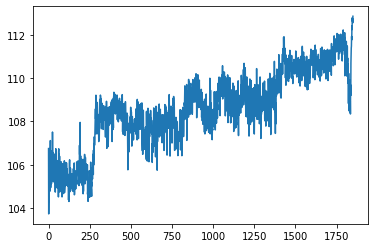

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [ ]:
ga = np.array(ga)
ba = np.array(ba)

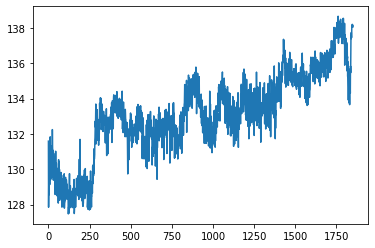

In [ ]:
plt.plot(ga)

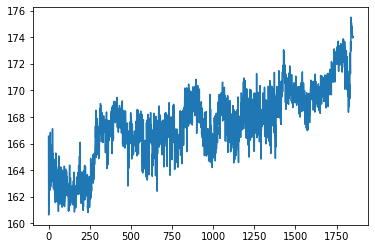

In [ ]:
plt.plot(ba)

In [ ]:
X = np.array(list(zip(ra,ga,ba)))

In [ ]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=3)

In [ ]:
X_transformed = transformer.fit_transform(X)

In [ ]:
X_indep = X_transformed.transpose()

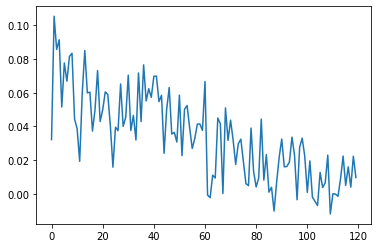

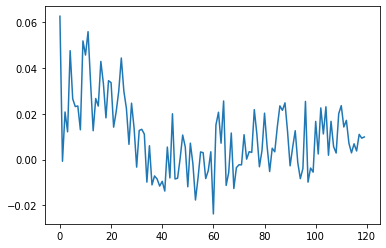

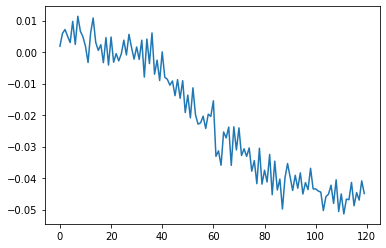

In [ ]:
plt.plot(X_indep[0][:120])
plt.show()
plt.plot(X_indep[1][:120])
plt.show()
plt.plot(X_indep[2][:120])
plt.show()

In [ ]:
from scipy import signal
x1 = X_indep[1] - X_indep[1].mean()
x1_corr = signal.correlate(x1, x1, mode='same')

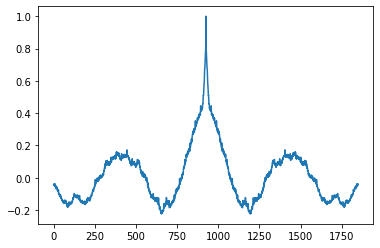

In [ ]:

plt.plot(x1_corr)

In [ ]:
ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])

In [ ]:
fs_n = 30/len(x1_corr/2)

In [ ]:
4/fs_n

246.66666666666666

In [ ]:
0.75/fs_n

46.25

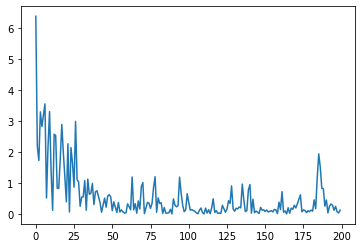

In [ ]:
plt.plot((abs(ff[46:246])))

In [ ]:
(np.argmax(abs(ff[46:241])) + 46)*60*fs_n

44.75675675675676

In [ ]:
np.max(abs(ff[46:241]))

6.373217181004755

In [ ]:
from scipy.stats import kurtosis as kurt

In [ ]:
x2 = X_indep[2] - X_indep[2].mean()
x2_corr = signal.correlate(x2, x2, mode='same')

In [ ]:

ff = np.fft.hfft(x2_corr[:int(len(x2_corr)/2)])

In [ ]:

(np.argmax(abs(ff[41:241])) + 41)*60*fs_n

45.72972972972973

In [ ]:
np.max(abs(ff[46:241]))

0.7599331044389289

In [ ]:
x0 = X_indep[0] - X_indep[0].mean()
x0_corr = signal.correlate(x0, x0, mode='same')

In [ ]:
ff = np.fft.hfft(x0_corr[:int(len(x0_corr)/2)])

In [ ]:
(np.argmax(abs(ff[46:241])) + 46)*60*fs_n

60.32432432432433

In [ ]:
np.max(abs(ff[46:241]))

8.740963751587797